# Regression -- Survival Duration

Attempt to train a model to predict how long a patient will
survive after a heart attack.

Use data cleaning from `ecg_tools` module in this package, as developed in `initial_exploration` notebook.

In [1]:
%pylab inline
from collections import OrderedDict

import pandas
import numpy
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR, NuSVR
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
import seaborn


import ecg_tools

Populating the interactive namespace from numpy and matplotlib


Start by loading the data and taking a quick peek with a scatterplot matrix.

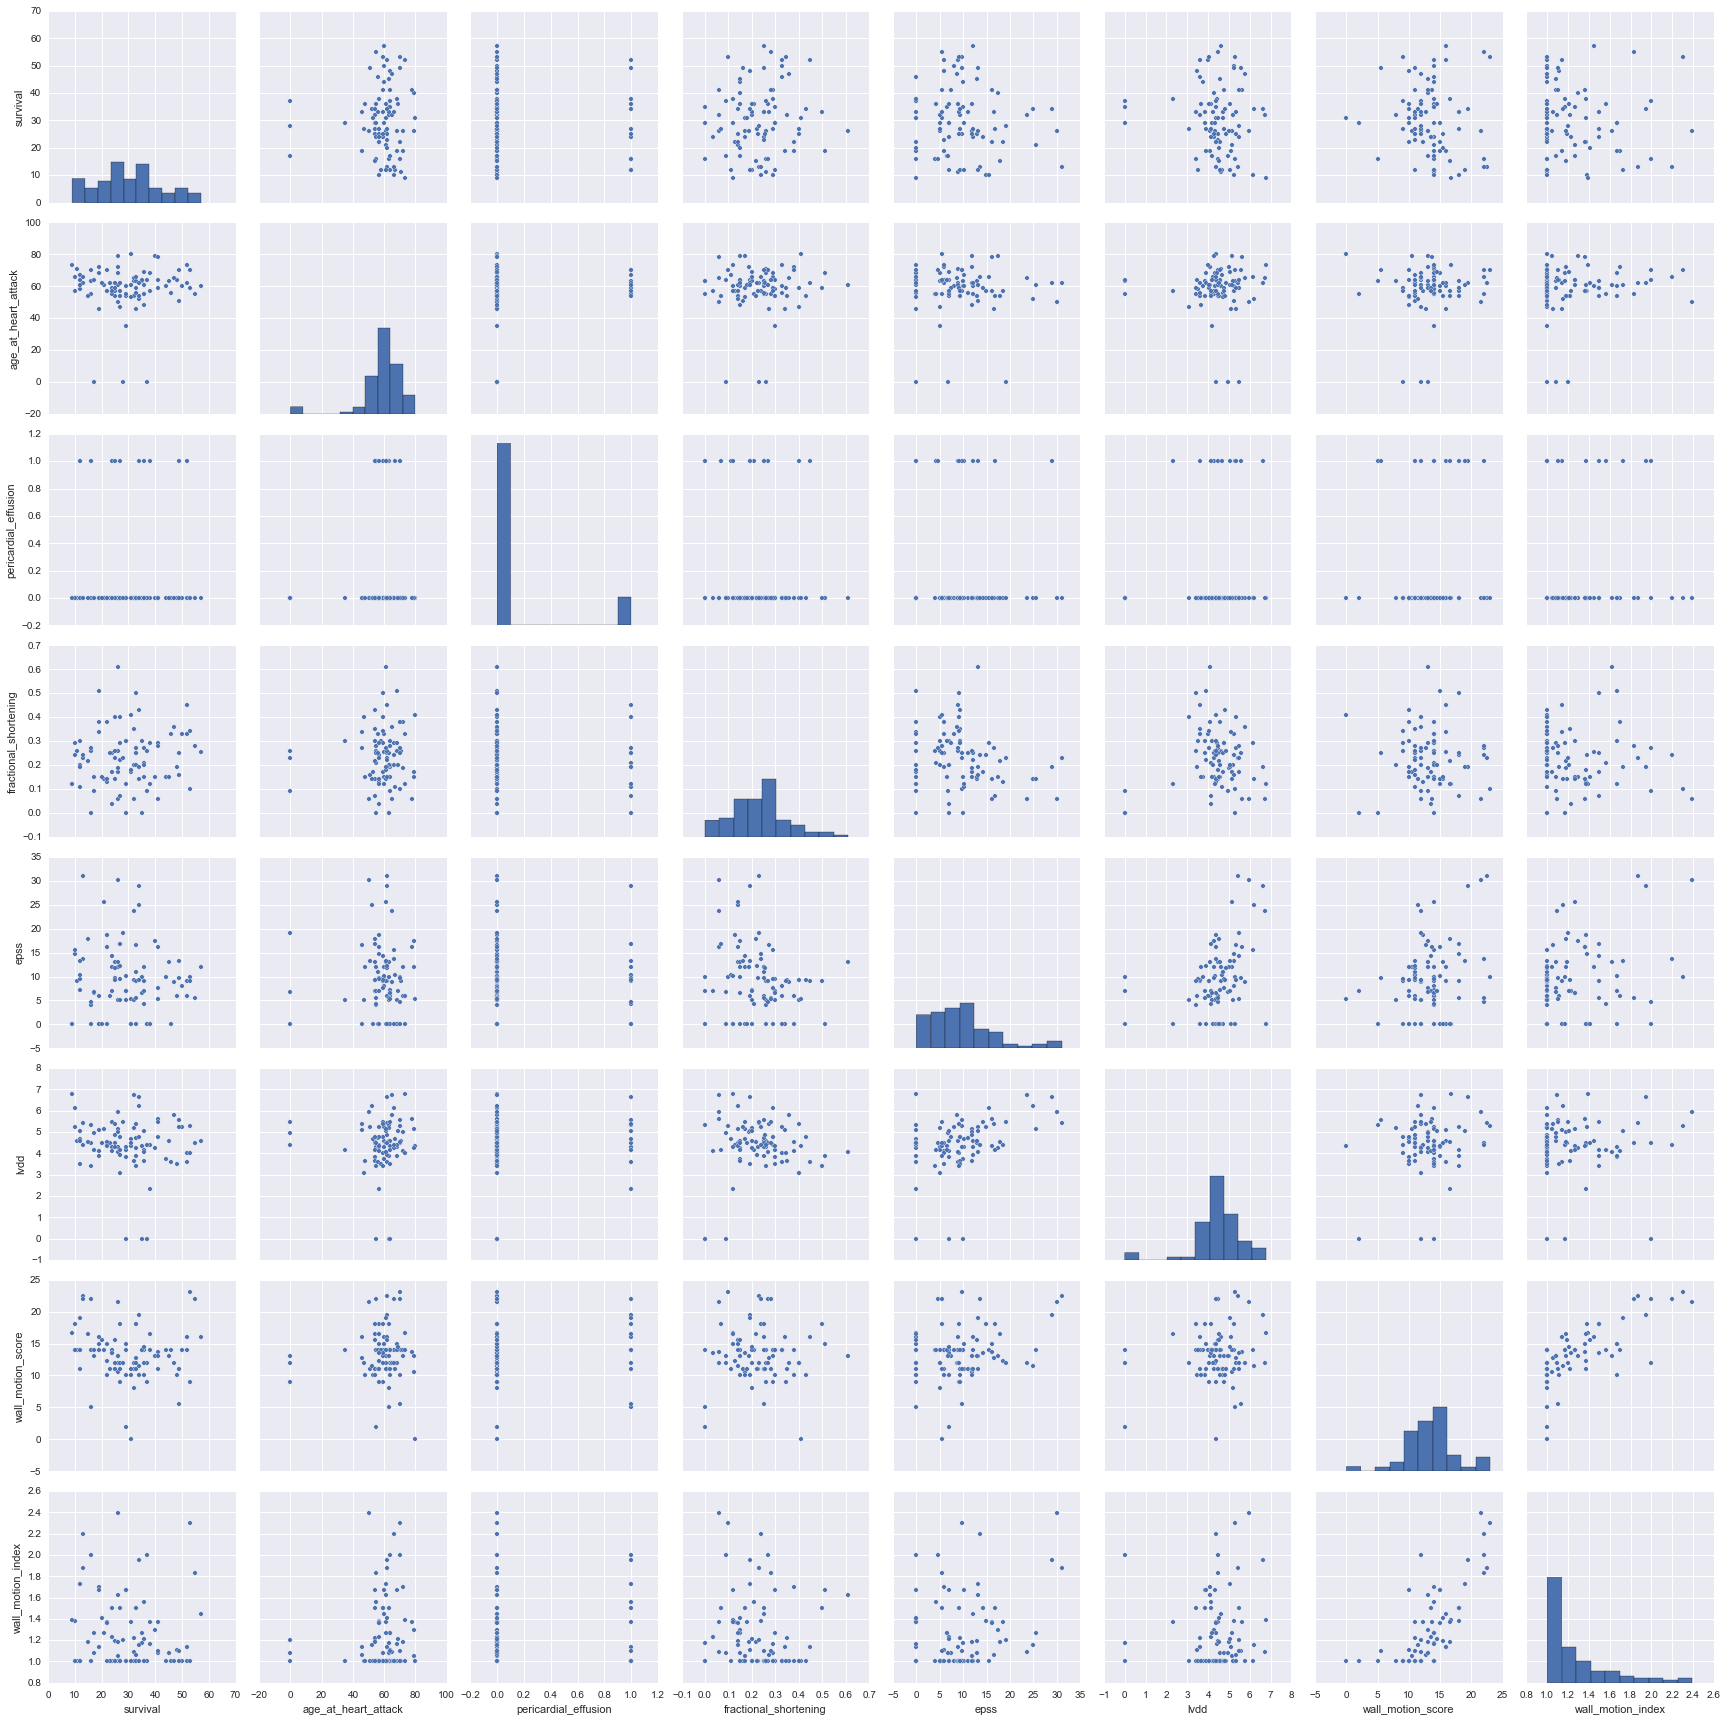

In [2]:
ecg = ecg_tools.loadData()
# Make a version with no NaNs because Seaborn doesn't like them
ecgNoMissing = ecg.fillna(0)
seaborn.pairplot(ecgNoMissing)


We can see from the top row that no one variable has great
correlation with the target variable, `survival`

## Replace missing values

We can do the basic thing, just replace missing values with the
median of the distribution.


In [3]:
for columnName in ecg.keys():
  median = ecg[columnName].median()
  ecg[columnName] = ecg[columnName].fillna(median)
# Make sure that worked
ecg.isnull().any()

survival                 False
age_at_heart_attack      False
pericardial_effusion     False
fractional_shortening    False
epss                     False
lvdd                     False
wall_motion_score        False
wall_motion_index        False
dtype: bool

Ok, great, there are no more NaNs in the dataframe.

## Inputs and outputs, feature normalization


Convert to numpy arrays.  


In [4]:
# Make a copy of the data
features = ecg.copy()
# pop off the regression target
target = features.pop('survival')
# Change from months to years
target = target 

Normalize features by mean and stadard deviation

In [5]:

for columnName in features.keys():
  mean = features[columnName].mean()
  std = features[columnName].std()
  features[columnName] = (features[columnName] - mean) / std


Now take a look at the result with seaborn to make sure we got
what we wanted.

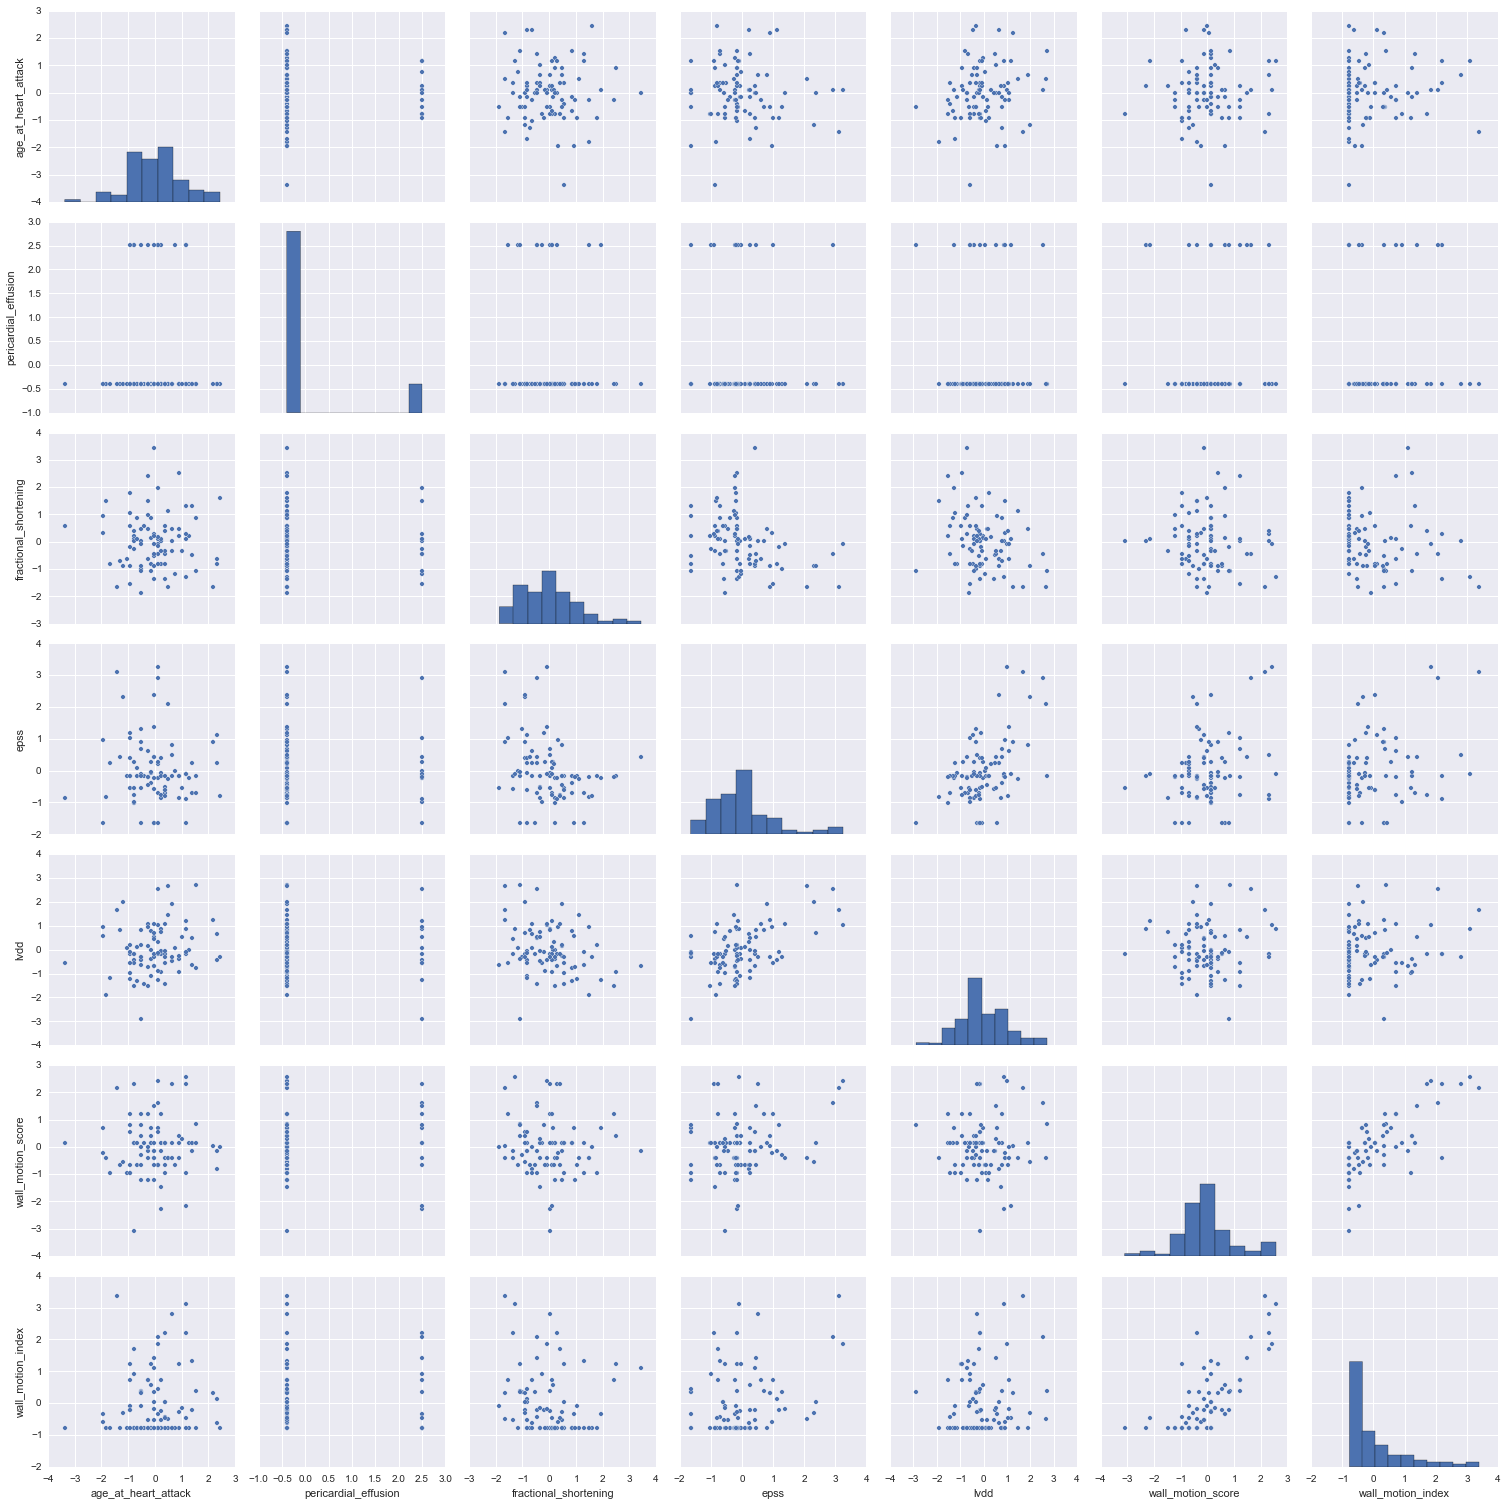

In [6]:
seaborn.pairplot(features)

There is very little covariance visible here.  Probably
no reason to do any dimensionality reduction.



## Train/test split

Split off 20% of data for testing later


In [7]:
# make a train/test mask
mask = numpy.random.rand(len(features)) < 0.8

# Create train and test inputs
trainX = numpy.array(features[mask])
testX = numpy.array(features[~mask])
# Create train and test outputs
trainY = numpy.array(target[mask])
testY = numpy.array(target[~mask])



## Fitting and model selection

Use scikit to train suppport vector machine regression.  Scikit also
does grid search. 

The grid search will make it easy 

Write a function which fits a model and shows the result on the training set.



In [8]:
def trainShow(model, trainX, trainY):
  ## Fit the model.  Everything from scikit implements fit 
  model.fit(trainX, trainY)
  
  try:
    ## In the case of GridSearchCV, we can show the best parameters
    print model.best_params_
    print model.best_score_
  except:
    print "Best params not implemented for model: %s" % type(model)
  # Plot the prediction for the test set
  predY = model.predict(trainX)
  plot = pyplot.scatter(trainY, predY)
  pyplot.xlabel("True Survival")                          
  pyplot.ylabel("Predicted Survival")

def testShow(model, testX, testY):
  predY = model.predict(testX)
  pyplot.scatter(testY, predY)
  pyplot.xlabel("True Survival")                          
  pyplot.ylabel("Predicted Survival")
    
  print ((predY - testY)**2).sum() / len(predY)

def mse(model, testX, testY):
  predY = model.predict(testX)
  return ((predY - testY)**2).sum() / len(predY)


## Basic Linear Regression

Best params not implemented for model: <class 'sklearn.linear_model.base.LinearRegression'>


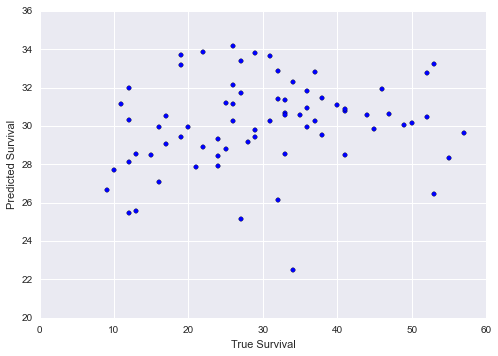

In [9]:
lr = LinearRegression()

trainShow(lr, trainX, trainY)


That fails to fit the training set very well.

## Lasso regression


{'alpha': 3.3076497807442427}
-0.0278420857174


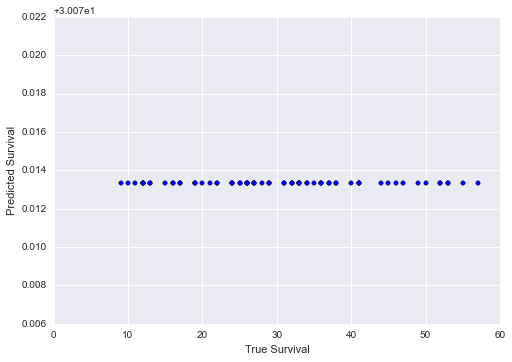

In [10]:
lasso = GridSearchCV(
                   Lasso(),
                   cv=5,
                   param_grid={
                      "alpha": numpy.logspace(-3, 3, 1000),
                     }
                   )
trainShow(lasso, trainX, trainY)

This just went towards real hard regularization which has 
no shape.  That's no good. 

## Ridge regression

{'alpha': 1000.0}
-0.0274745825411


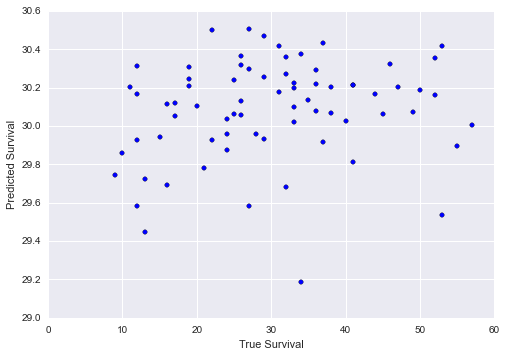

In [11]:
ridge = GridSearchCV(
                   Ridge(),
                   cv=5,
                   param_grid={
                      "alpha": numpy.logspace(-3, 3, 1000),
                     }
                   )
trainShow(ridge, trainX, trainY)

## Nearest neigbors regression

{'n_neighbors': 40, 'weights': 'distance', 'algorithm': 'ball_tree'}
-0.0469257647475


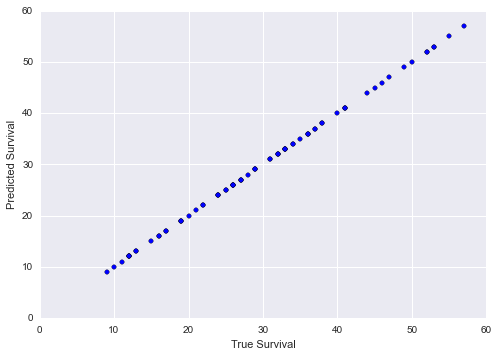

In [12]:
neighbor = GridSearchCV(
                   KNeighborsRegressor(),
                   cv=5,
                   param_grid={
                      "n_neighbors": [5, 10, 25, 40],
                      "weights": ["uniform", "distance"],
                      "algorithm":["ball_tree", "kd_tree", "brute"]
                     }
                   )
trainShow(neighbor, trainX, trainY)

## Support Vector Regression

{'epsilon': 0.0001, 'C': 6.1584821106602607, 'gamma': 0.46415888336127775, 'kernel': 'rbf'}
0.00711553215524


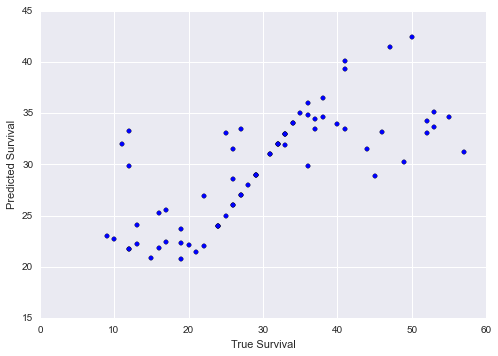

In [13]:
svr = GridSearchCV(
                   SVR(),
                   cv=5,
                   param_grid={
                      "kernel":["rbf"],
                      "C": numpy.logspace(-3, 6, 20),
                      "gamma": numpy.logspace(-3, 3, 10),
                      "epsilon": numpy.logspace(-6, 0, 10)
                     }
                   )
    
trainShow(svr, trainX, trainY)

## Kernel Ridge Regression

{'alpha': 0.46415888336127775, 'gamma': 0.001, 'degree': 1, 'kernel': 'poly'}
-0.0275136502935


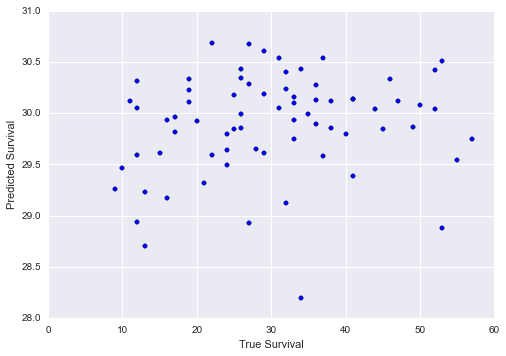

In [14]:
kridge = GridSearchCV(
                   KernelRidge(),
                   cv=5,
                   param_grid={
                      "alpha": numpy.logspace(-3, 3, 10),
                      "kernel":["rbf", "linear", "poly"],
                      "gamma": numpy.logspace(-3, 3, 10),
                      "degree":[1,2,3]
                     }
                   )
trainShow(kridge, trainX, trainY)

## Test MSE

Take a look at the mean square error on the test sample for these
models.


In [15]:
models = OrderedDict()
models["lr"] = lr
models["lasso"] = lasso
models["ridge"] = ridge
models["kridge"] = kridge
models["svr"] = svr
models["neighbor"] = neighbor

for name, model in models.items():
  print "%s: %s" % (name, mse(model, testX, testY))
    

lr: 98.9232488776
lasso: 97.4340277778
ridge: 97.0083634704
kridge: 96.5386013402
svr: 113.334842691
neighbor: 101.57879808


Those are all pretty terrible.

Look at lasso and ridge

# Lasso test

97.4340277778


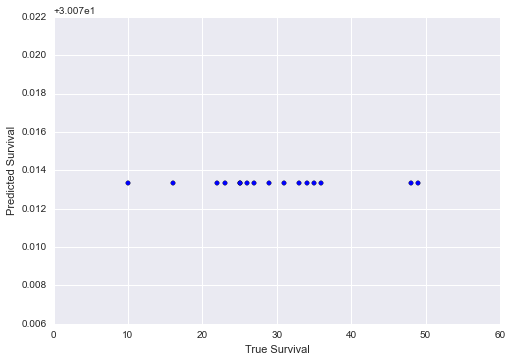

In [16]:
testShow(lasso, testX, testY)

## Ridge test

97.0083634704


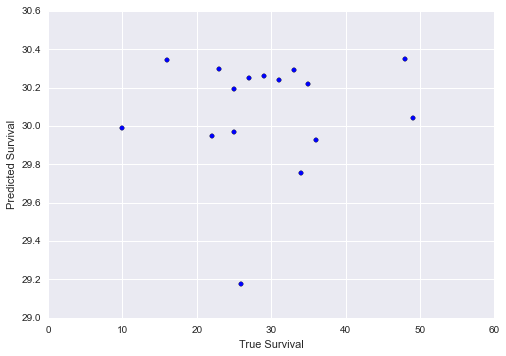

In [17]:
testShow(ridge, testX, testY)